In [362]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import losses
from keras import optimizers
from keras import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from google.colab import drive
from keras.utils import to_categorical
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
matplotlib.rcParams['figure.facecolor'] = '#ffffff'
drive.mount('/content/drive')

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Part 1

##Part 1.1

###Part 1. 1 a - Read the ‘Signals.csv’ as DataFrame and import required libraries.

In [363]:
signal_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Neural Network and Deep Learning Project/Signal.csv')
signal_df.head()

,Parameter 1,Parameter 2,Parameter 3,Parameter 4,Parameter 5,Parameter 6,Parameter 7,Parameter 8,Parameter 9,Parameter 10,Parameter 11,Signal_Strength
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


###Part 1.1 b - Check for missing values and print percentage for each attribute.

In [364]:
missing_values = signal_df.isnull().sum()
missing_percentage = (missing_values / len(signal_df)) * 100
for column, percentage in missing_percentage.items():
    print(f"{column}: {percentage:.2f}% missing values")

Parameter 1: 0.00% missing values
Parameter 2: 0.00% missing values
Parameter 3: 0.00% missing values
Parameter 4: 0.00% missing values
Parameter 5: 0.00% missing values
Parameter 6: 0.00% missing values
Parameter 7: 0.00% missing values
Parameter 8: 0.00% missing values
Parameter 9: 0.00% missing values
Parameter 10: 0.00% missing values
Parameter 11: 0.00% missing values
Signal_Strength: 0.00% missing values


###Part 1.1 c - Check for presence of duplicate records in the dataset and impute with appropriate method

In [365]:
duplicates = signal_df[signal_df.duplicated()]
print(f"There are {len(duplicates)} duplicate rows.")
print(f"Before removing duplicates, the dataset has {len(signal_df)} rows.")
signal_df = signal_df.drop_duplicates()
print(f"After removing duplicates, the dataset has {len(signal_df)} rows.")

There are 240 duplicate rows.
Before removing duplicates, the dataset has 1599 rows.
After removing duplicates, the dataset has 1359 rows.


###Part 1.1 d- Visualise distribution of the target variable

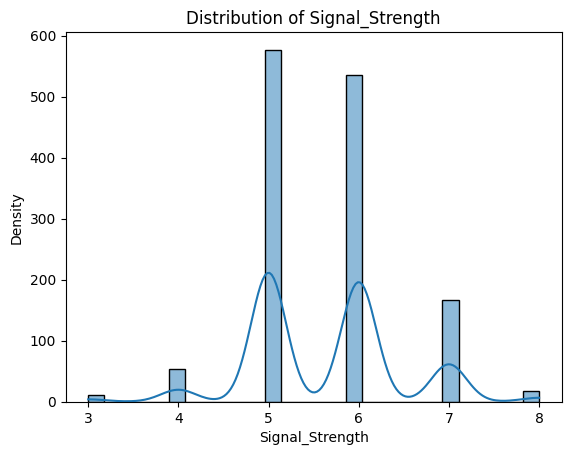

In [366]:
sns.histplot(signal_df['Signal_Strength'], kde=True)
plt.title('Distribution of Signal_Strength')
plt.xlabel('Signal_Strength')
plt.ylabel('Density')
plt.show()

###Part 1.1 e- - Share insights from the initial data analysis (at least 2).

In [367]:
signal_df.Signal_Strength.describe()

count    1359.000000
mean        5.623252
std         0.823578
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: Signal_Strength, dtype: float64

**Insights:**


1.   The data has a range from 3 to 8.
2.   The mean (5.62) is slightly lower than the median (6). This suggests a slight skewness in the distribution of the data towards the lower side, though the difference is not drastic.
3. The interquartile range (IQR), which is the difference between the 75th percentile (Q3) and the 25th percentile (Q1), is only 1 (6 - 5 = 1). This indicates that the middle 50% of the data is quite tightly packed, with values ranging just between 5 and 6.
4. The standard deviation of 0.82 further emphasizes that the majority of the data points are clustered close to the mean.
5. There might be a concentration of data points around the values of 5 and 6 since both the 25th and 75th percentiles have values of 5 and 6 respectively.

##Part 1.2

###Part 1.2 a - Split the data into X & Y.

In [368]:
x = signal_df.drop(['Signal_Strength'], axis=1)
y = signal_df[['Signal_Strength']]

###Part 1.2 b - Split the data into train & test with 70:30 proportion

In [369]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

###Part 1.2 c - Print shape of all the 4 variables and verify if train and test data is in sync

In [370]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

if X_train.shape[0] == y_train.shape[0] and X_test.shape[0] == y_test.shape[0]:
    print("Train and test data are in sync.")
else:
    print("Train and test data are NOT in sync.")

X_train shape: (951, 11)
y_train shape: (951, 1)
X_test shape: (408, 11)
y_test shape: (408, 1)
Train and test data are in sync.


###Part 1.2 d - Normalise the train and test data with appropriate method..

In [371]:
X_train_scaled = X_train.apply(zscore)
X_test_scaled = X_test.apply(zscore)

###Part 1.2 e - Transform Labels into format acceptable by Neural Network

In [372]:
y = signal_df[['Signal_Strength']]

# One Hot encoding
y_encoded = pd.get_dummies(y).values
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))

# Spliting and normalizing
X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.3, random_state=42)
X_train_scaled = X_train.apply(zscore)
X_test_scaled = X_test.apply(zscore)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

if X_train.shape[0] == y_train.shape[0] and X_test.shape[0] == y_test.shape[0]:
    print("Train and test data are in sync.")
else:
    print("Train and test data are NOT in sync.")

X_train shape: (951, 11)
y_train shape: (951, 6)
X_test shape: (408, 11)
y_test shape: (408, 6)
Train and test data are in sync.


##Part 1.3

###Part 1.3 a - Design a Neural Network to train a classifier

In [373]:
model = Sequential()
model.add(Dense(32, input_dim=11, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(6, activation='softmax')) ### For multiclass classification Softmax is used

In [374]:
adam = optimizers.Adam(lr=1e-3)
model.compile(loss=losses.categorical_crossentropy, optimizer=adam, metrics=['accuracy']) ### Loss function = Categorical cross entropy

In [375]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           (None, 32)                384       
                                                                 
 dense_103 (Dense)           (None, 16)                528       
                                                                 
 dense_104 (Dense)           (None, 6)                 102       
                                                                 
Total params: 1,014
Trainable params: 1,014
Non-trainable params: 0
_________________________________________________________________


###Part 1.3 b - Train the classifier using previously designed Architecture

In [376]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',
                            save_weights_only=True, mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,model='auto')

callbacks = [checkpoint,reduce_lr]

In [377]:
history=model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=128, verbose=2,callbacks=callbacks)

Epoch 1/10

Epoch 1: saving model to model_weights.h5
6/6 - 1s - loss: 8.9000 - accuracy: 0.1197 - val_loss: 7.5444 - val_accuracy: 0.1361 - lr: 0.0010 - 735ms/epoch - 123ms/step
Epoch 2/10

Epoch 2: saving model to model_weights.h5
6/6 - 0s - loss: 5.8646 - accuracy: 0.1316 - val_loss: 4.3924 - val_accuracy: 0.1728 - lr: 0.0010 - 103ms/epoch - 17ms/step
Epoch 3/10

Epoch 3: saving model to model_weights.h5
6/6 - 0s - loss: 3.2603 - accuracy: 0.1816 - val_loss: 2.4725 - val_accuracy: 0.4188 - lr: 0.0010 - 110ms/epoch - 18ms/step
Epoch 4/10

Epoch 4: saving model to model_weights.h5
6/6 - 0s - loss: 2.3639 - accuracy: 0.4237 - val_loss: 2.3764 - val_accuracy: 0.4450 - lr: 0.0010 - 98ms/epoch - 16ms/step
Epoch 5/10

Epoch 5: saving model to model_weights.h5
6/6 - 0s - loss: 2.1577 - accuracy: 0.4421 - val_loss: 1.9662 - val_accuracy: 0.4450 - lr: 0.0010 - 100ms/epoch - 17ms/step
Epoch 6/10

Epoch 6: saving model to model_weights.h5
6/6 - 0s - loss: 1.7231 - accuracy: 0.4539 - val_loss: 1

###Part 1.3 c - Plot 2 separate visuals.
 1. Training Loss and Validation Loss
 2.  Training Accuracy and Validation Accuracy

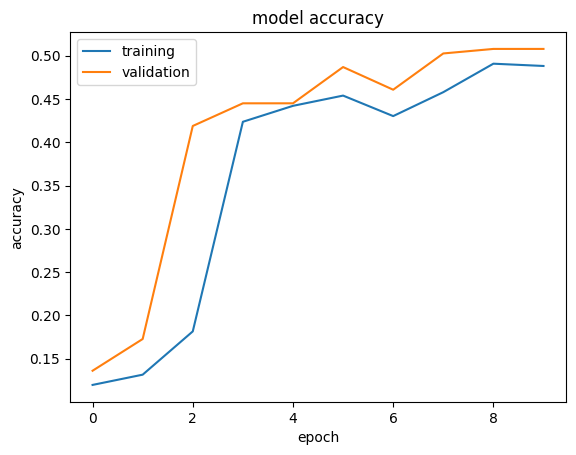

In [378]:
loss, accuracy  = model.evaluate(X_test, y_test, verbose=False)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

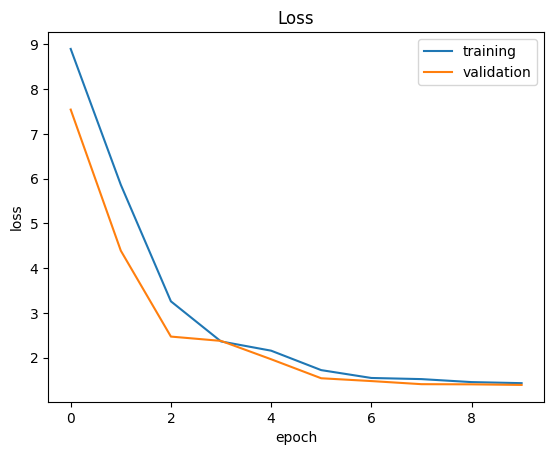

In [379]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

###Part 1.3 d - Design new architecture/update existing architecture in attempt to improve the performance of the model.

In [380]:
model_1 = Sequential()

model_1.add(Dense(256, activation='relu',input_dim=11,kernel_initializer='he_uniform')) ###Multiple Dense units with Relu activation
model_1.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
model_1.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))## Weight Initialization
model_1.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
model_1.add(Dropout(0.5))
model_1.add(BatchNormalization())
model_1.add(Dense(6, activation='softmax')) ### For multiclass classification Softmax is used

In [381]:
# Compile model
adam = optimizers.Adam(lr=1e-3)
model_1.compile(loss=losses.categorical_crossentropy, optimizer=adam, metrics=['accuracy']) ### Loss function = Categorical cross entropy

In [382]:
model_1.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_105 (Dense)           (None, 256)               3072      
                                                                 
 dense_106 (Dense)           (None, 64)                16448     
                                                                 
 dense_107 (Dense)           (None, 64)                4160      
                                                                 
 dense_108 (Dense)           (None, 32)                2080      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 batch_normalization_12 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                     

In [383]:
checkpoint = ModelCheckpoint("model_weights_1.h5",monitor='val_accuracy',
                            save_weights_only=True, model='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,model='auto')

callbacks = [checkpoint,reduce_lr]

In [384]:
history=model_1.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=128, verbose=2, callbacks=callbacks)

Epoch 1/10

Epoch 1: saving model to model_weights_1.h5
6/6 - 1s - loss: 2.1144 - accuracy: 0.1658 - val_loss: 1.8234 - val_accuracy: 0.3927 - lr: 0.0010 - 946ms/epoch - 158ms/step
Epoch 2/10

Epoch 2: saving model to model_weights_1.h5
6/6 - 0s - loss: 1.9900 - accuracy: 0.1882 - val_loss: 1.4394 - val_accuracy: 0.4764 - lr: 0.0010 - 84ms/epoch - 14ms/step
Epoch 3/10

Epoch 3: saving model to model_weights_1.h5
6/6 - 0s - loss: 1.9457 - accuracy: 0.2316 - val_loss: 1.4253 - val_accuracy: 0.4712 - lr: 0.0010 - 89ms/epoch - 15ms/step
Epoch 4/10

Epoch 4: saving model to model_weights_1.h5
6/6 - 0s - loss: 1.9107 - accuracy: 0.2132 - val_loss: 1.3914 - val_accuracy: 0.4869 - lr: 0.0010 - 76ms/epoch - 13ms/step
Epoch 5/10

Epoch 5: saving model to model_weights_1.h5
6/6 - 0s - loss: 1.8499 - accuracy: 0.2316 - val_loss: 1.4218 - val_accuracy: 0.5288 - lr: 0.0010 - 88ms/epoch - 15ms/step
Epoch 6/10

Epoch 6: saving model to model_weights_1.h5
6/6 - 0s - loss: 1.8337 - accuracy: 0.2724 - va

###Part 1.3 e - Plot visuals as in Q3.C and share insights about difference observed in both the models.


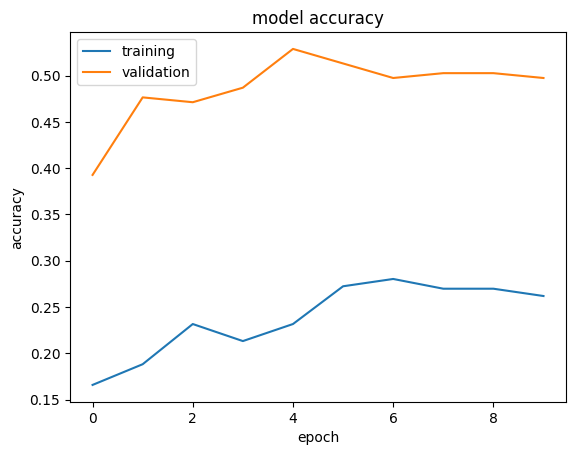

In [385]:
loss, accuracy  = model_1.evaluate(X_test, y_test, verbose=False)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

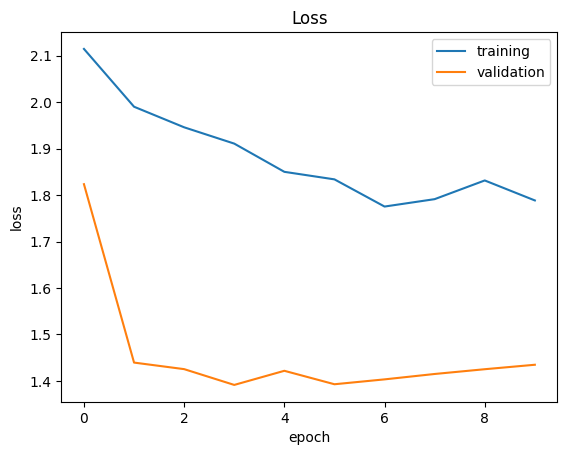

In [386]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

**Summary**

1. We can observe from our both models that model with batch normalization and dropout is performing similar in terms of misclassifications.
2. However, the accuracy curve for train and validation shows that our model with dropout and batch normalization is much less an overfit.
3. Loss function is keep reducing as the epoch


#Part 2

##Part 2.1

###Part 2.1 a - Read the .h5 file and assign to a variable.

###Part 2.1 b - Print all the keys from the .h5 file.

###Part 2.1 c - Split the data into X_train, X_test, Y_train, Y_test

In [387]:
import h5py
filename = "/content/drive/MyDrive/Colab Notebooks/Neural Network and Deep Learning Project/Autonomous_Vehicles_SVHN_single_grey1.h5"

with h5py.File(filename, "r") as f:
    keys = f.keys()
    print("Keys: %s" % keys)
    X_test = f.get('X_test')[:]
    X_train = f.get('X_train')[:]
    X_val = f.get('X_val')[:]
    y_test = f.get('y_test')[:]
    y_train = f.get('y_train')[:]
    y_val = f.get('y_val')[:]
f.close()

Keys: <KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>


###Part 2.2 a - Print shape of all the 4 data split into x, y, train, test to verify if x & y is in sync

In [388]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

if X_train.shape[0] == y_train.shape[0] and X_test.shape[0] == y_test.shape[0]:
    print("Train and test data are in sync.")
else:
    print("Train and test data are NOT in sync.")

X_train shape: (42000, 32, 32)
y_train shape: (42000,)
X_test shape: (18000, 32, 32)
y_test shape: (18000,)
Train and test data are in sync.


###Part 2.2 b - Visualise first 10 images in train data and print its corresponding labels..

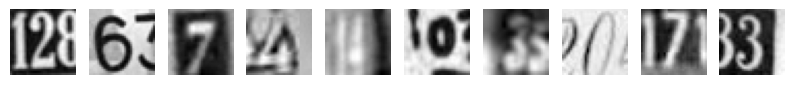

label for each of the above image: [2 6 7 4 4 0 3 0 7 3]


In [389]:
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_train[0:10]))

###Part 2.2 c - Reshape all the images with appropriate shape update the data in same variable.

In [390]:
image_vector_size = 32*32
X_train = X_train.reshape(X_train.shape[0], image_vector_size)
X_test = X_test.reshape(X_test.shape[0], image_vector_size)

###Part 2.2 d - Normalise the images i.e. Normalise the pixel values.

In [391]:
# # normalize inputs from 0-255 to 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0

print('Training set', X_train.shape, y_train.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (42000, 1024) (42000,)
Test set (18000, 1024) (18000,)


###Part 2.2 e - Transform Labels into format acceptable by Neural Network

In [392]:
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test_cat=to_categorical(y_test,num_classes)
print("First 5 training lables as one-hot encoded vectors:\n", y_train[:5])

First 5 training lables as one-hot encoded vectors:
 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


###Part 2.2 f - Print total Number of classes in the Dataset.

In [393]:
unique_values = np.unique(y_val)
print("Unique values:", unique_values)

Unique values: [0 1 2 3 4 5 6 7 8 9]


###Part 2.3 a - Design a Neural Network to train a classifier.

In [394]:
image_size=32*32
model_2 = Sequential()
model_2.add(Dense(256, activation='relu',kernel_initializer='he_uniform',input_shape=(image_size,))) ###Multiple Dense units with Relu activation
model_2.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
model_2.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))## Weight Initialization
model_2.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
model_2.add(Dropout(0.5))
model_2.add(BatchNormalization())
model_2.add(Dense(num_classes, activation='softmax'))

In [395]:
# Compile model
adam = optimizers.Adam(lr=1e-3)
model_2.compile(loss=losses.categorical_crossentropy, optimizer=adam, metrics=['accuracy']) ### Loss function = Categorical cross entropy

In [396]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           (None, 32)                384       
                                                                 
 dense_103 (Dense)           (None, 16)                528       
                                                                 
 dense_104 (Dense)           (None, 6)                 102       
                                                                 
Total params: 1,014
Trainable params: 1,014
Non-trainable params: 0
_________________________________________________________________


###Part 2.3 b - Train the classifier using previously designed Architecture (Use best suitable parameters).

In [397]:
checkpoint = ModelCheckpoint("model_weights_1.h5",monitor='val_accuracy',
                            save_weights_only=True, model='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,model='auto')

callbacks = [checkpoint,reduce_lr]

In [398]:
history=model_2.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=128, verbose=2, callbacks=callbacks)

Epoch 1/10

Epoch 1: saving model to model_weights_1.h5
263/263 - 2s - loss: 2.4350 - accuracy: 0.1012 - val_loss: 2.3158 - val_accuracy: 0.1055 - lr: 0.0010 - 2s/epoch - 8ms/step
Epoch 2/10

Epoch 2: saving model to model_weights_1.h5
263/263 - 1s - loss: 2.3247 - accuracy: 0.1013 - val_loss: 2.3074 - val_accuracy: 0.0952 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 3/10

Epoch 3: saving model to model_weights_1.h5
263/263 - 1s - loss: 2.3085 - accuracy: 0.1007 - val_loss: 2.3030 - val_accuracy: 0.1014 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 4/10

Epoch 4: saving model to model_weights_1.h5
263/263 - 2s - loss: 2.3043 - accuracy: 0.1030 - val_loss: 2.3029 - val_accuracy: 0.1035 - lr: 0.0010 - 2s/epoch - 9ms/step
Epoch 5/10

Epoch 5: saving model to model_weights_1.h5
263/263 - 2s - loss: 2.3032 - accuracy: 0.1044 - val_loss: 2.3031 - val_accuracy: 0.0971 - lr: 0.0010 - 2s/epoch - 8ms/step
Epoch 6/10

Epoch 6: saving model to model_weights_1.h5
263/263 - 2s - loss: 2.3033 - accuracy: 0.09

###Part 2.3 c - Evaluate performance of the model with appropriate metrics.

In [399]:
torch.cuda.is_available()

True

In [400]:
# predicting the model on test data
y_pred=model_2.predict(X_test)

563/563 [==============================] - 1s 2ms/step


In [401]:
y_pred_final=[]
for i in y_pred:
  y_pred_final.append(np.argmax(i))

In [402]:
y_pred_final[0]

5

In [403]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_final))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1814
           1       0.11      0.07      0.08      1828
           2       0.11      0.27      0.16      1803
           3       0.08      0.00      0.00      1719
           4       0.00      0.00      0.00      1812
           5       0.10      0.71      0.17      1768
           6       0.00      0.00      0.00      1832
           7       0.00      0.00      0.00      1808
           8       0.00      0.00      0.00      1812
           9       0.00      0.00      0.00      1804

    accuracy                           0.10     18000
   macro avg       0.04      0.10      0.04     18000
weighted avg       0.04      0.10      0.04     18000



###Part 2.3 d - Plot the training loss, validation loss vs number of epochs and training accuracy, validation accuracy vs number of epochs plot and write your observations on the same

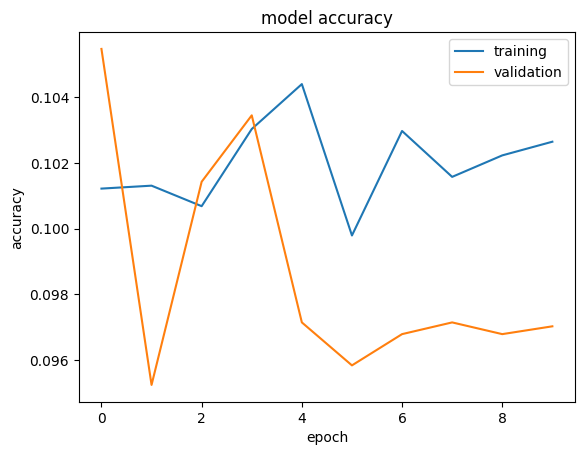

In [404]:
loss, accuracy  = model_2.evaluate(X_test, y_test_cat, verbose=False)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

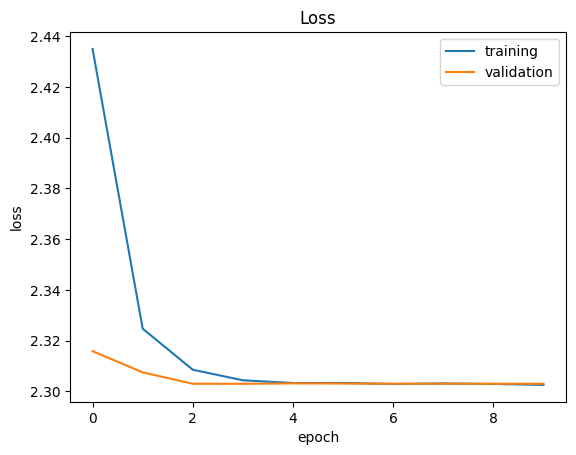

In [405]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

**Summary**

1. We can observe from our model with batch normalization and dropout is performing similar in terms of misclassifications.
2. However, the accuracy curve for train and validation shows that our model with dropout and batch normalization is much less an overfit.
3. Loss function is keep reducing as the epoch


In [409]:
%%shell
jupyter nbconvert --to html /content/Neural_Network_and_Deep_Learning.ipynb

[NbConvertApp] Converting notebook /content/Neural_Network_and_Deep_Learning.ipynb to html
[NbConvertApp] Writing 1009992 bytes to /content/Neural_Network_and_Deep_Learning.html
